In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report
from tabulate import tabulate

import warnings, pickle
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/heart_2020_cleaned.csv")
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


<Axes: >

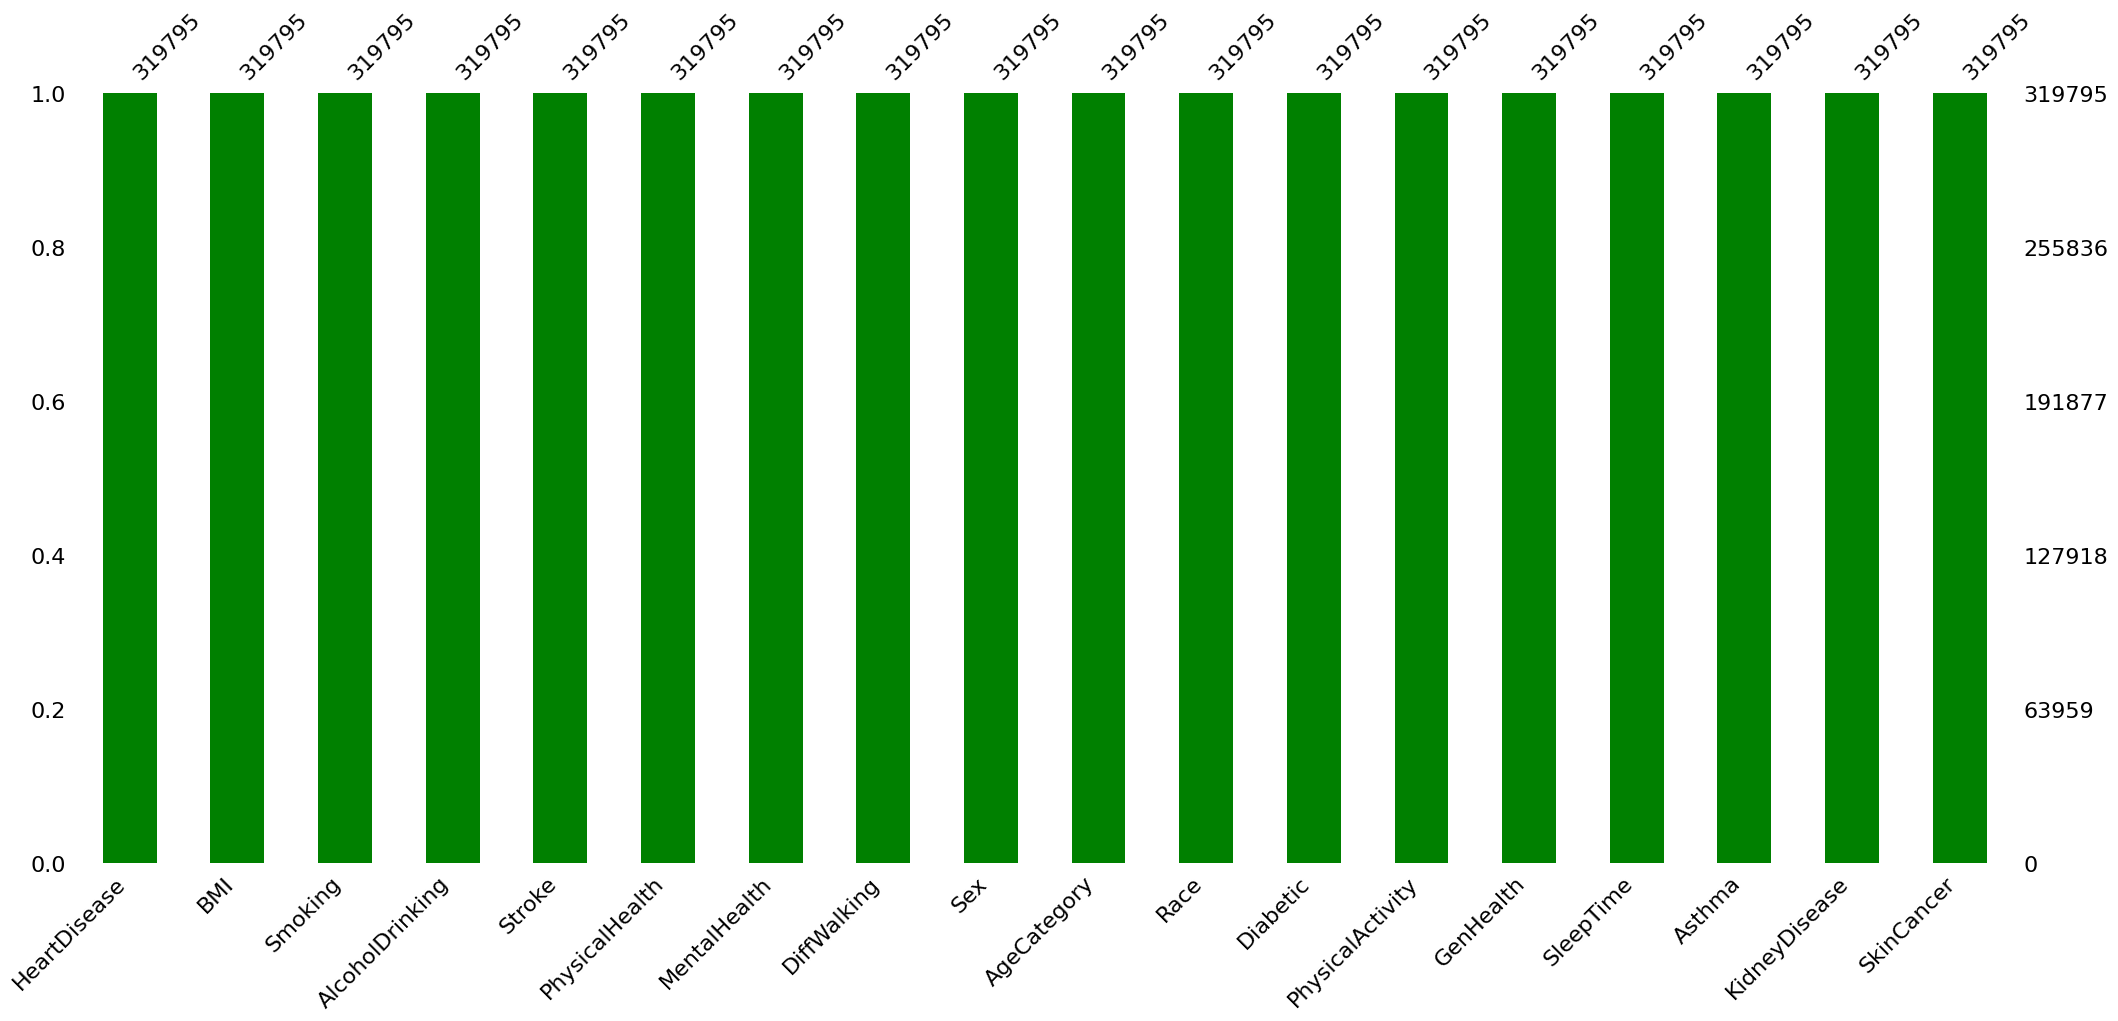

In [ ]:
msno.bar(df, color = 'g')

In [ ]:
print(f"Summary Of The Dataset with numerical columns :")
df.describe()

Summary Of The Dataset with numerical columns :


,BMI,PhysicalHealth,MentalHealth,SleepTime
count,319795.000000,319795.00000,319795.000000,319795.000000
mean,28.325399,3.37171,3.898366,7.097075
std,6.356100,7.95085,7.955235,1.436007
min,12.020000,0.00000,0.000000,1.000000
25%,24.030000,0.00000,0.000000,6.000000
50%,27.340000,0.00000,0.000000,7.000000
75%,31.420000,2.00000,3.000000,8.000000
max,94.850000,30.00000,30.000000,24.000000


In [ ]:
print(f"Total number of duplicate rows: {df.duplicated().sum()}")
print("---------------")
print(f"Total Missing Values          : {df.isnull().sum().sum()}")

Total number of duplicate rows: 18078
---------------
Total Missing Values          : 0


In [ ]:
df.drop_duplicates(inplace=True)

Encoding Part

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 301717 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      301717 non-null  object 
 1   BMI               301717 non-null  float64
 2   Smoking           301717 non-null  object 
 3   AlcoholDrinking   301717 non-null  object 
 4   Stroke            301717 non-null  object 
 5   PhysicalHealth    301717 non-null  float64
 6   MentalHealth      301717 non-null  float64
 7   DiffWalking       301717 non-null  object 
 8   Sex               301717 non-null  object 
 9   AgeCategory       301717 non-null  object 
 10  Race              301717 non-null  object 
 11  Diabetic          301717 non-null  object 
 12  PhysicalActivity  301717 non-null  object 
 13  GenHealth         301717 non-null  object 
 14  SleepTime         301717 non-null  float64
 15  Asthma            301717 non-null  object 
 16  KidneyDisease     301717 

In [ ]:
for column in df.columns:
    num_distinct_values = len(df[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")


HeartDisease: 2 distinct values
BMI: 3604 distinct values
Smoking: 2 distinct values
AlcoholDrinking: 2 distinct values
Stroke: 2 distinct values
PhysicalHealth: 31 distinct values
MentalHealth: 31 distinct values
DiffWalking: 2 distinct values
Sex: 2 distinct values
AgeCategory: 13 distinct values
Race: 6 distinct values
Diabetic: 4 distinct values
PhysicalActivity: 2 distinct values
GenHealth: 5 distinct values
SleepTime: 24 distinct values
Asthma: 2 distinct values
KidneyDisease: 2 distinct values
SkinCancer: 2 distinct values


In [ ]:
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
numeric_cols

['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']

In [ ]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_cols

['HeartDisease',
 'Smoking',
 'AlcoholDrinking',
 'Stroke',
 'DiffWalking',
 'Sex',
 'AgeCategory',
 'Race',
 'Diabetic',
 'PhysicalActivity',
 'GenHealth',
 'Asthma',
 'KidneyDisease',
 'SkinCancer']

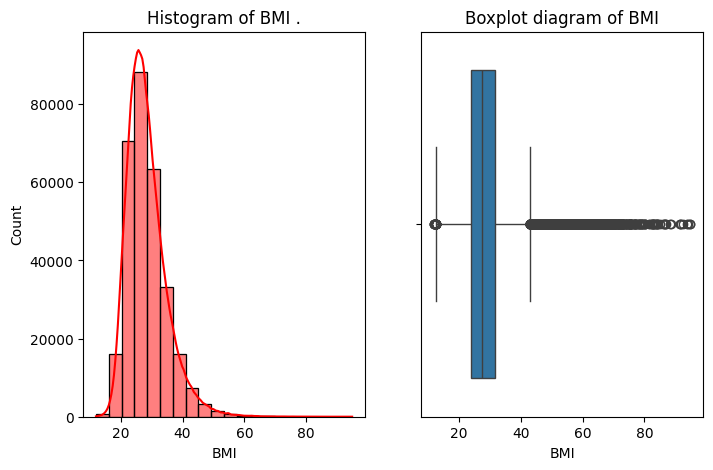

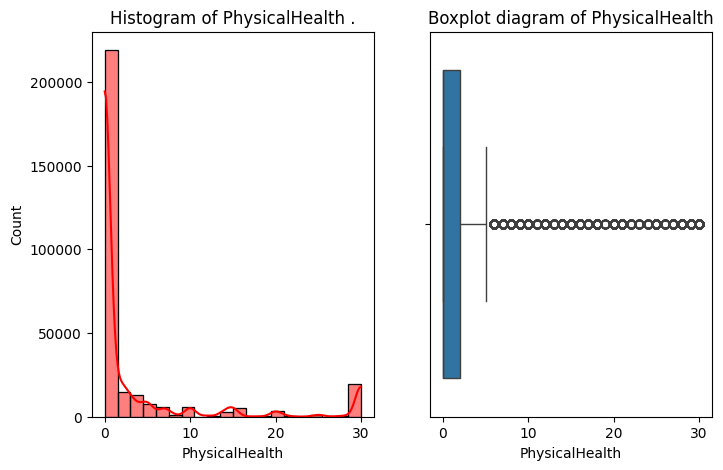

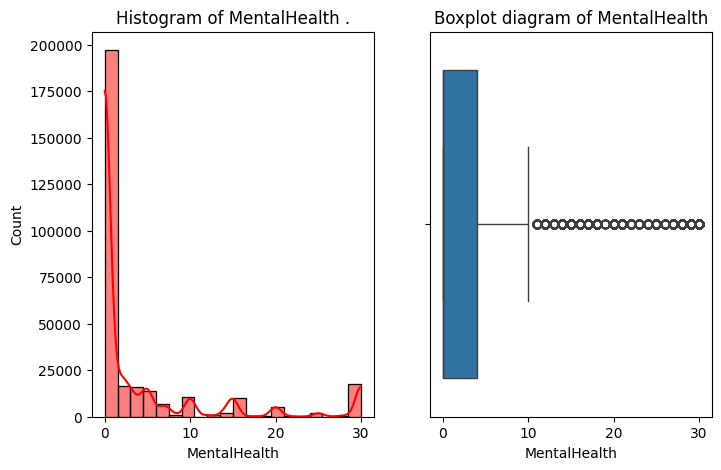

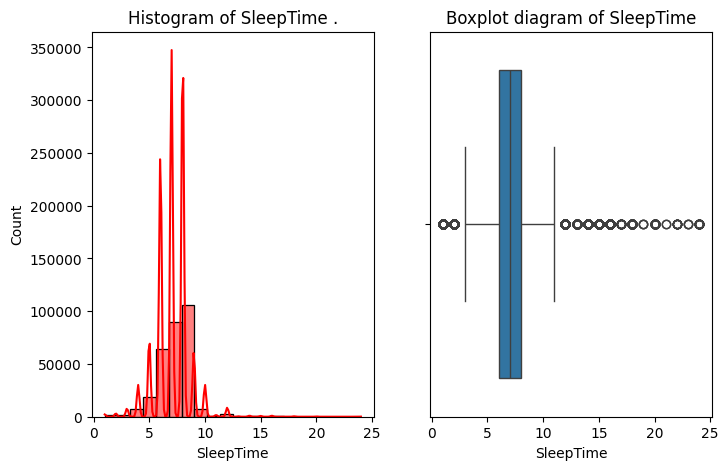

In [ ]:
def univariate_analysis_numeric(col):
    fig, ax = plt.subplots(1, 2, figsize=(8,5))
    sns.histplot(df[col], kde=True, bins=20, color='Red',ax=ax[0])
    ax[0].set_title(f'Histogram of {col} .')

    sns.boxplot(x=df[col],ax=ax[1])
    ax[1].set_title(f'Boxplot diagram of {col}')

for col in numeric_cols:
    # print(f' Univariate analysis for {col} column:')
    univariate_analysis_numeric(col)

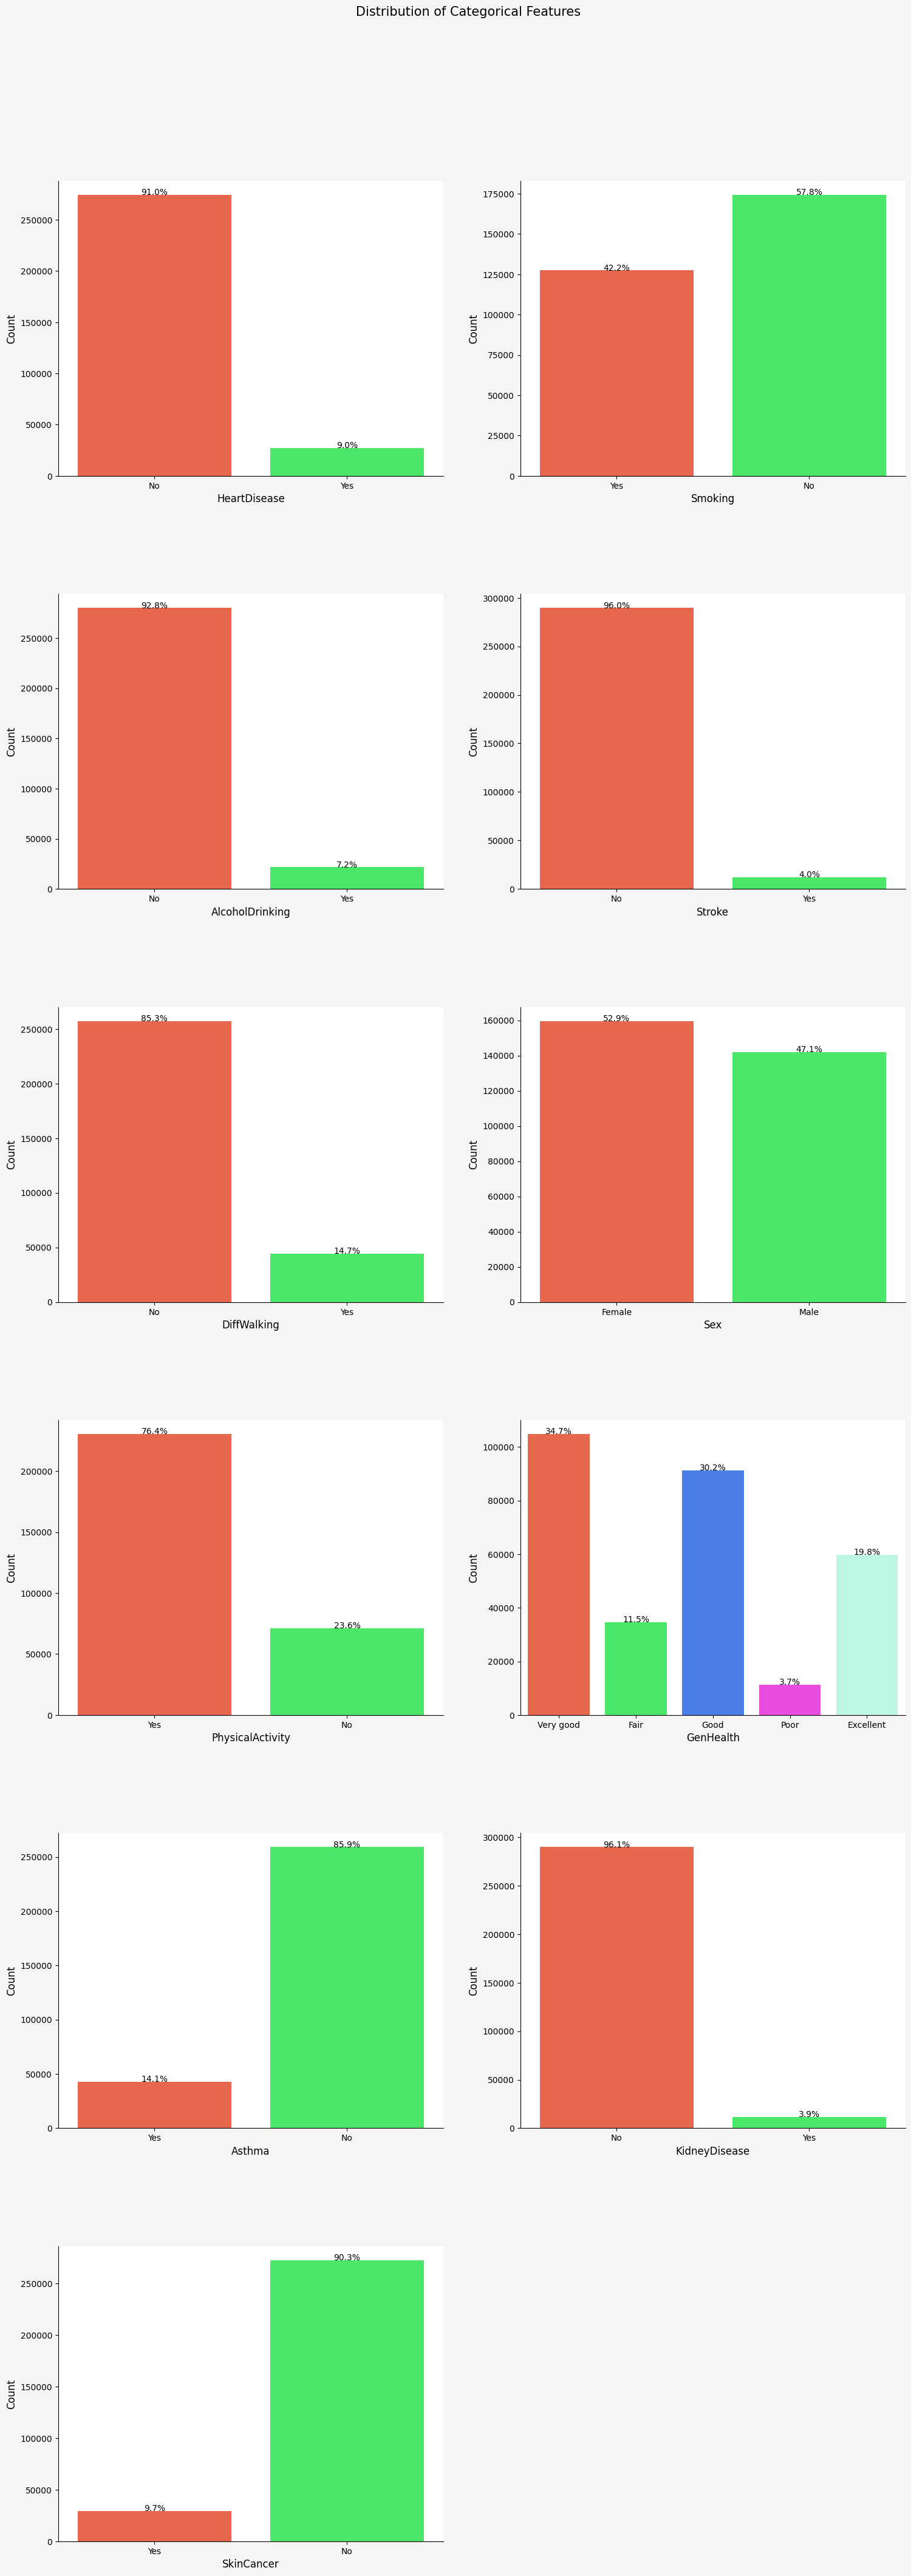

In [ ]:
cat_feats = ['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'PhysicalActivity', 'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer']
mypal = ['#FF5733', '#33FF57', '#3373FF', '#FF33F3', '#B4FFE4']

L = len(cat_feats)
ncol = 2
nrow = int(np.ceil(L / ncol))

fig, axs = plt.subplots(nrow, ncol, figsize=(18, 8 * nrow), facecolor='#F6F5F4')
fig.subplots_adjust(top=0.92, hspace=0.4, wspace=0.2)

i = 0
for col in cat_feats:
    ax = axs[i // ncol, i % ncol]
    sns.countplot(data=df, x=col, palette=mypal, ax=ax)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel("Count", fontsize=12)
    sns.despine(right=True, ax=ax)
    sns.despine(offset=0, trim=False, ax=ax)

    total = float(len(df))
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 3, '{:.1f}%'.format((height / total) * 100), ha="center")

    i += 1

if L % 2 != 0:
    axs[-1, -1].axis('off')

plt.suptitle('Distribution of Categorical Features', fontsize=15)
plt.show()

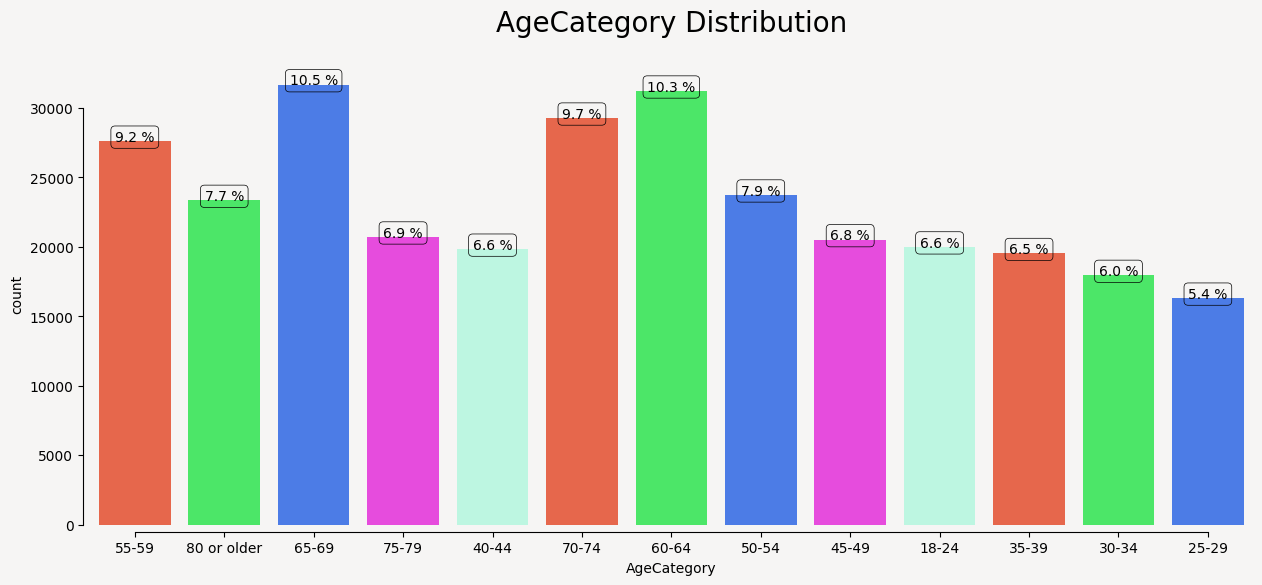

In [ ]:
plt.figure(figsize=(15, 6),facecolor='#F6F5F4')
total = float(len(df))
ax = sns.countplot(x=df['AgeCategory'], palette=mypal)
ax.set_facecolor('#F6F5F4')

for p in ax.patches:

    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.1f} %'.format((height/total)*100), ha="center",
           bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.5))

ax.set_title('AgeCategory Distribution', fontsize=20, y=1.05)
sns.despine(right=True)
sns.despine(offset=5, trim=True)

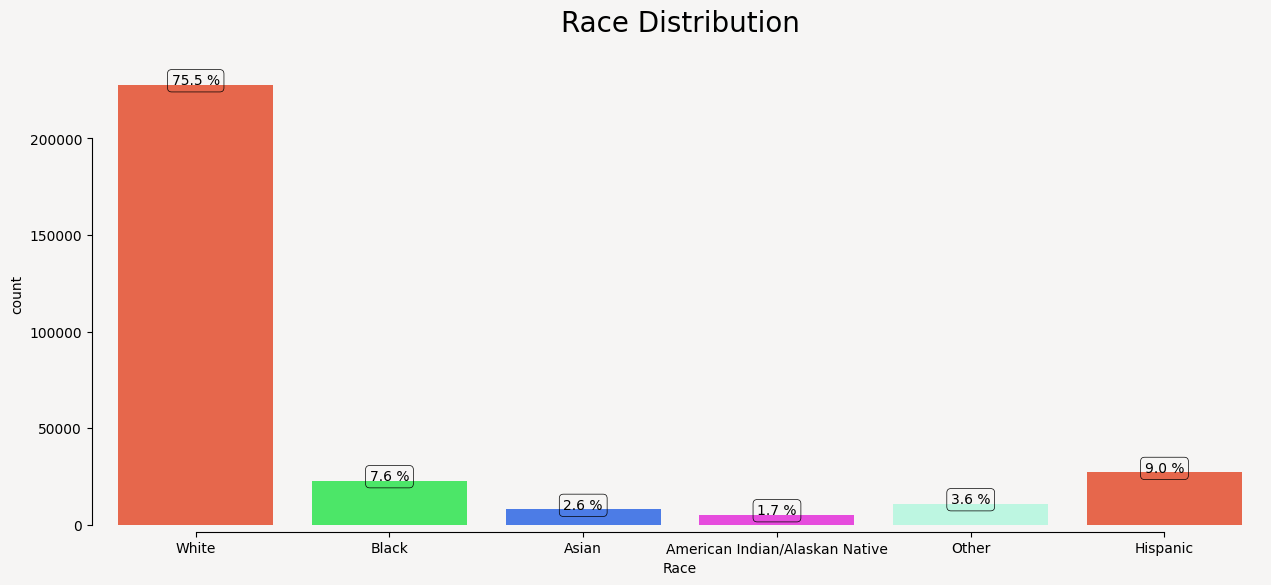

In [ ]:
plt.figure(figsize=(15, 6),facecolor='#F6F5F4')
total = float(len(df))
ax = sns.countplot(x=df['Race'], palette=mypal)
ax.set_facecolor('#F6F5F4')

for p in ax.patches:

    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.1f} %'.format((height/total)*100), ha="center",
           bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.5))

ax.set_title('Race Distribution', fontsize=20, y=1.05)
sns.despine(right=True)
sns.despine(offset=5, trim=True)

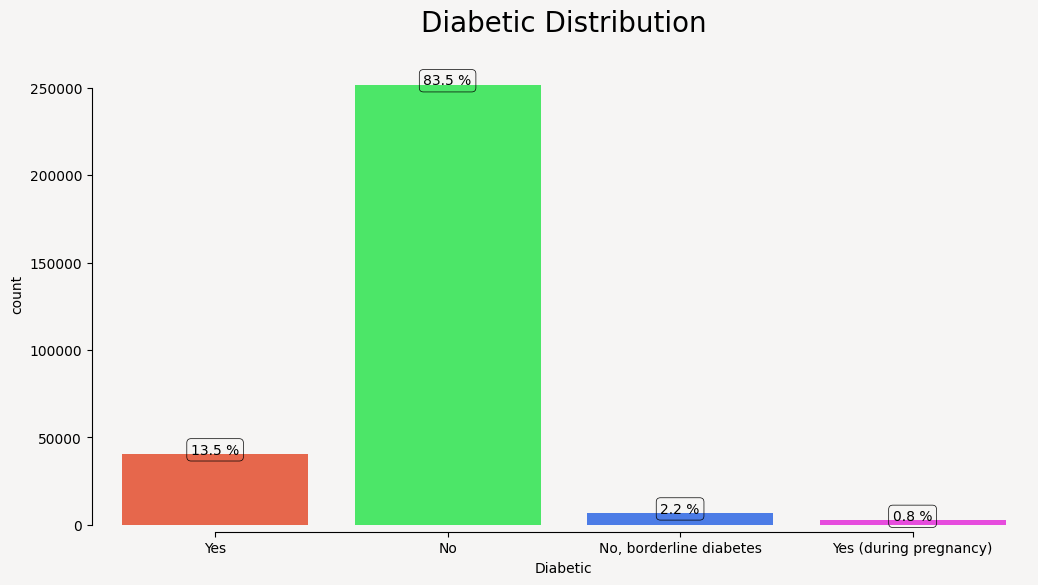

In [ ]:
plt.figure(figsize=(12, 6),facecolor='#F6F5F4')
total = float(len(df))
ax = sns.countplot(x=df['Diabetic'], palette=mypal)
ax.set_facecolor('#F6F5F4')

for p in ax.patches:

    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.1f} %'.format((height/total)*100), ha="center",
           bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.5))

ax.set_title('Diabetic Distribution', fontsize=20, y=1.05)
sns.despine(right=True)
sns.despine(offset=5, trim=True)

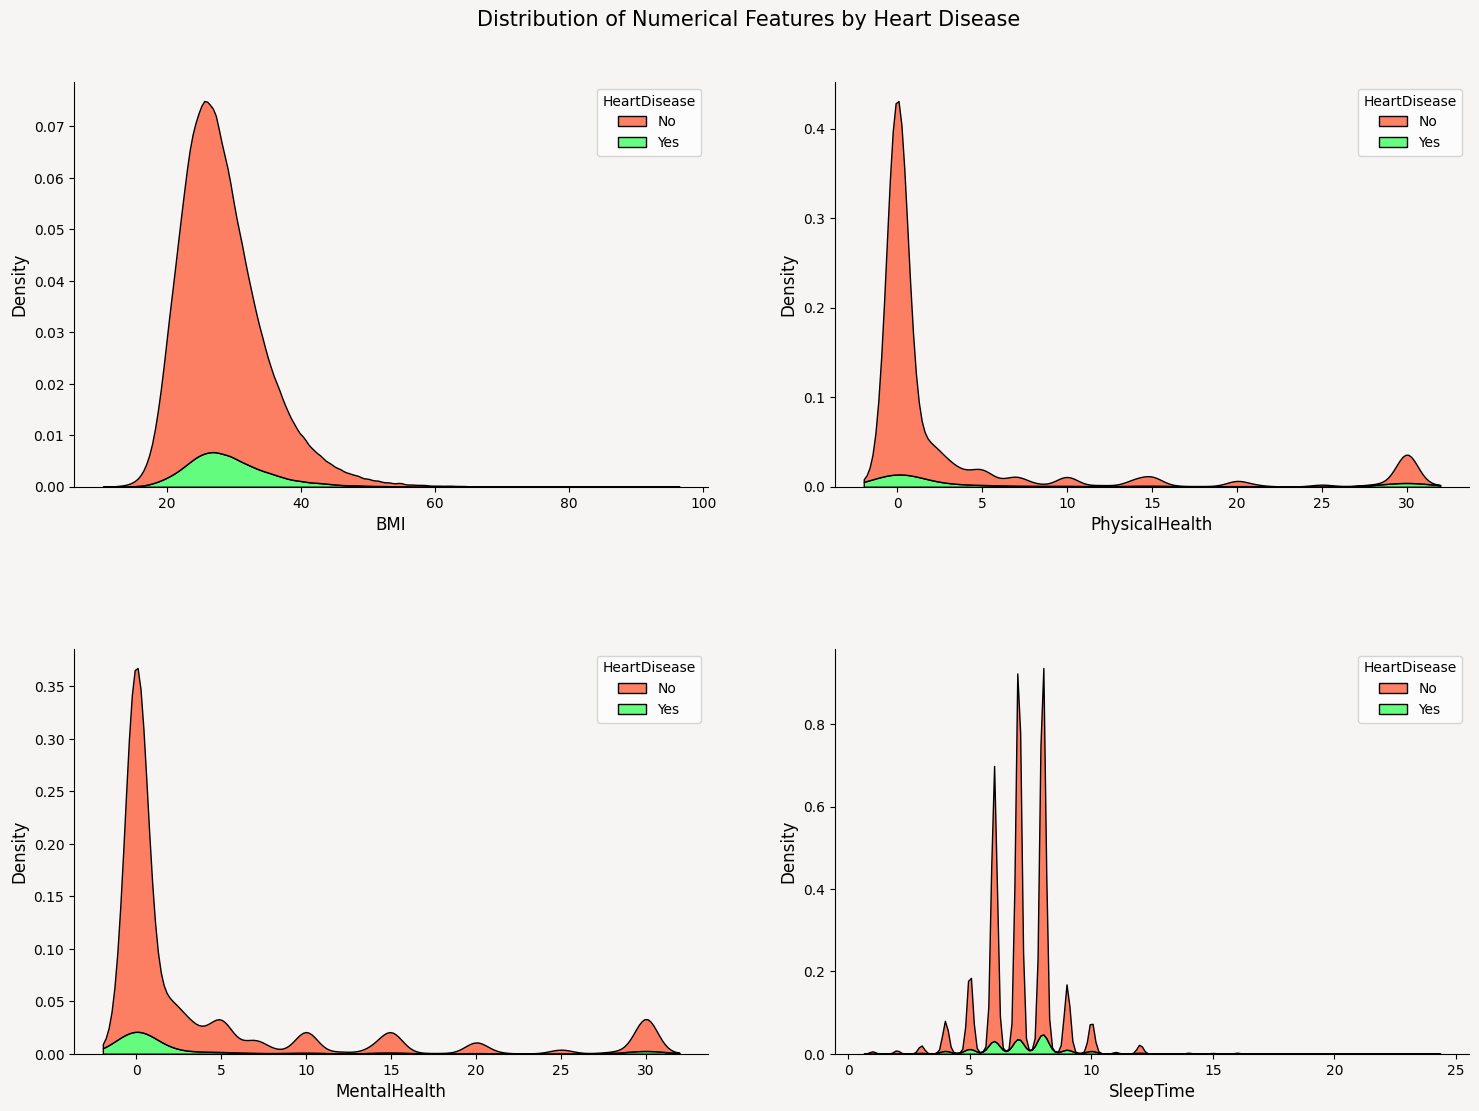

In [ ]:
num_feats = ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']

L = len(num_feats)
ncol = 2
nrow = int(np.ceil(L / ncol))

fig, ax = plt.subplots(nrow, ncol, figsize=(18, 6 * nrow), facecolor='#F6F5F4')
fig.subplots_adjust(top=0.92, hspace=0.4, wspace=0.2)

i = 0
for col in num_feats:
    plt.subplot(nrow, ncol, i + 1, facecolor='#F6F5F4')

    sns.kdeplot(data=df, x=col, hue="HeartDisease", multiple="stack", palette=mypal)
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Density", fontsize=12)
    sns.despine(right=True)
    sns.despine(offset=0, trim=False)

    i += 1

plt.suptitle('Distribution of Numerical Features by Heart Disease', fontsize=15)
plt.show()

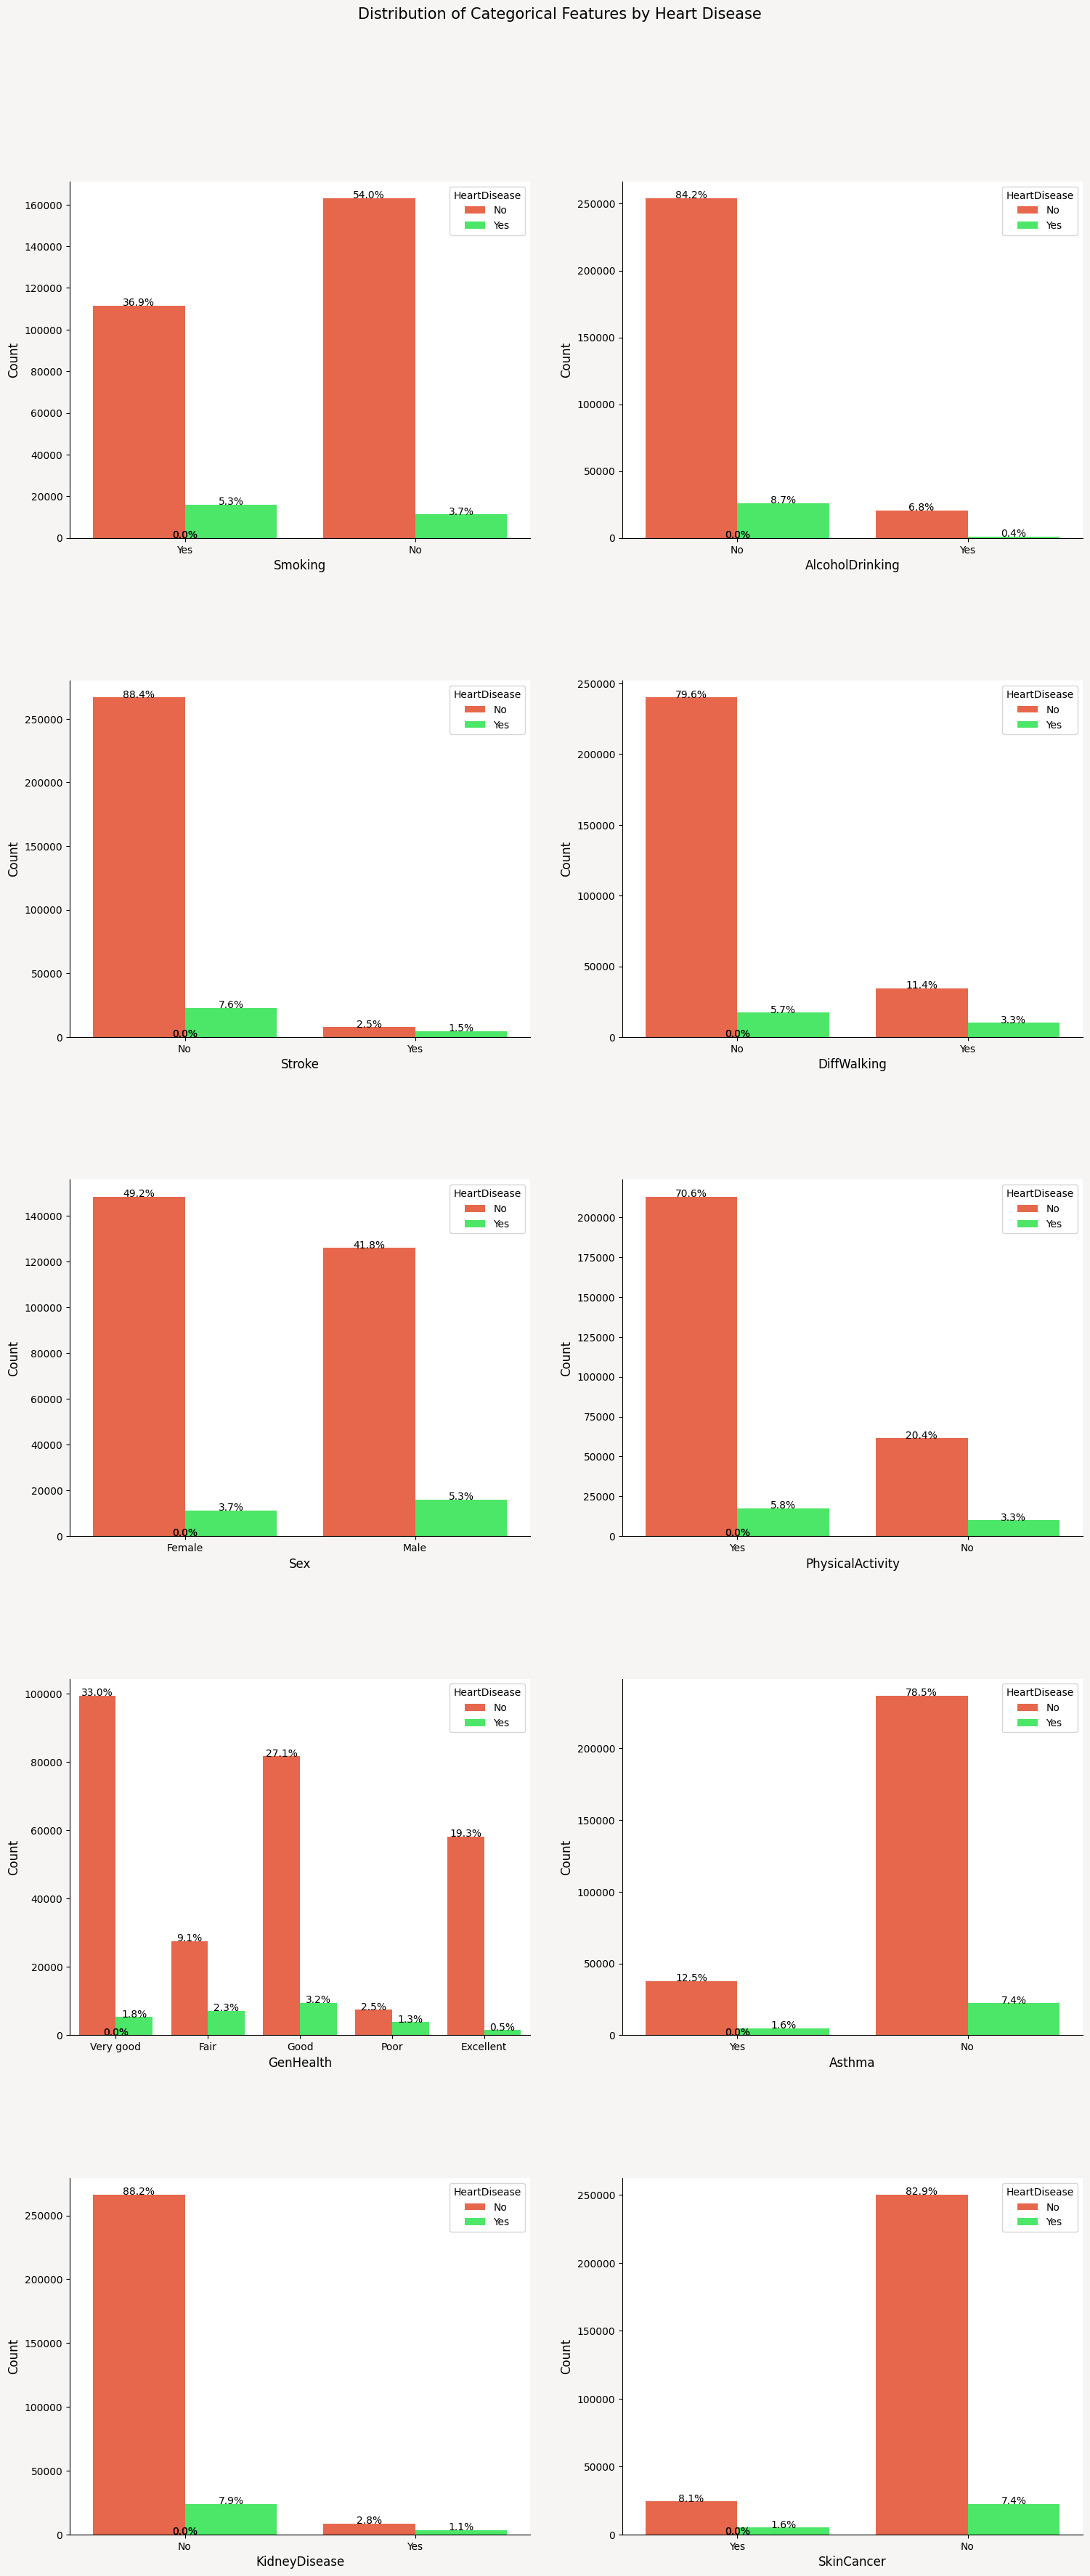

In [ ]:
cat_feats = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'PhysicalActivity', 'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer']

L = len(cat_feats)
ncol = 2
nrow = int(np.ceil(L / ncol))

fig, axs = plt.subplots(nrow, ncol, figsize=(18, 8 * nrow), facecolor='#F6F5F4')
fig.subplots_adjust(top=0.92, hspace=0.4, wspace=0.2)

for i, col in enumerate(cat_feats):
    ax = axs[i // ncol, i % ncol]
    sns.countplot(data=df, x=col, hue="HeartDisease", palette=mypal, ax=ax)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel("Count", fontsize=12)
    sns.despine(right=True, ax=ax)
    sns.despine(offset=0, trim=False, ax=ax)

    total = float(len(df))
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 3, '{:.1f}%'.format((height / total) * 100), ha="center")

if L % 2 != 0:
    axs[-1, -1].axis('off')

plt.suptitle('Distribution of Categorical Features by Heart Disease', fontsize=15)
plt.show()

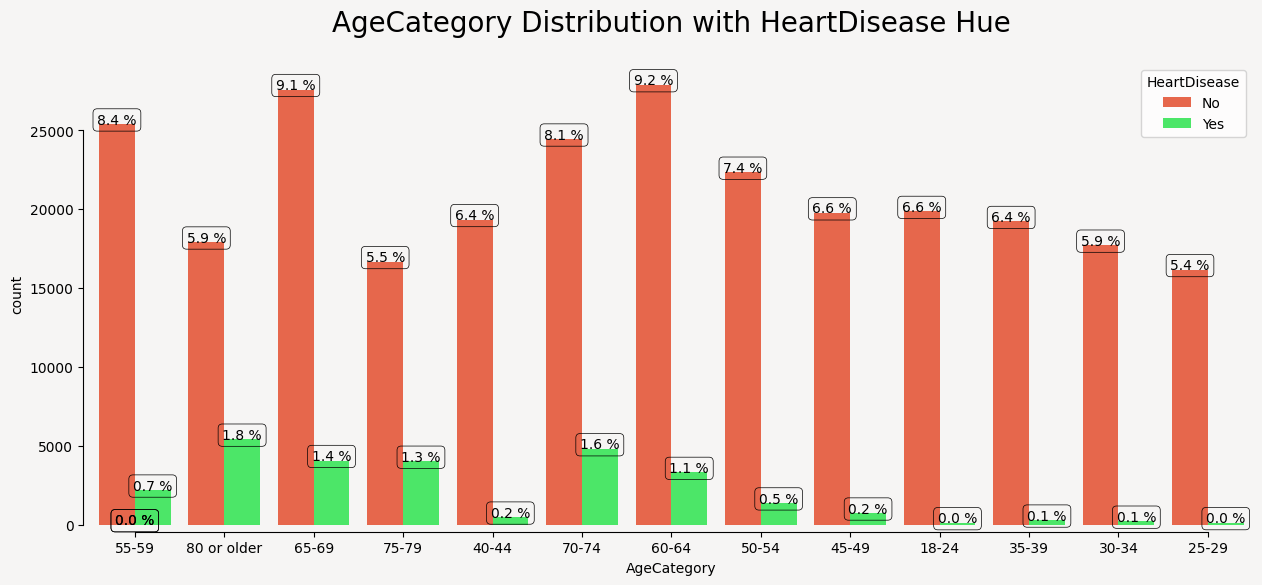

In [ ]:
plt.figure(figsize=(15, 6), facecolor='#F6F5F4')
total = float(len(df))

ax = sns.countplot(x='AgeCategory', hue='HeartDisease', data=df, palette=mypal)
ax.set_facecolor('#F6F5F4')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, '{:1.1f} %'.format((height / total) * 100), ha="center",
            bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.5))

ax.set_title('AgeCategory Distribution with HeartDisease Hue', fontsize=20, y=1.05)
sns.despine(right=True)
sns.despine(offset=5, trim=True)

plt.show()

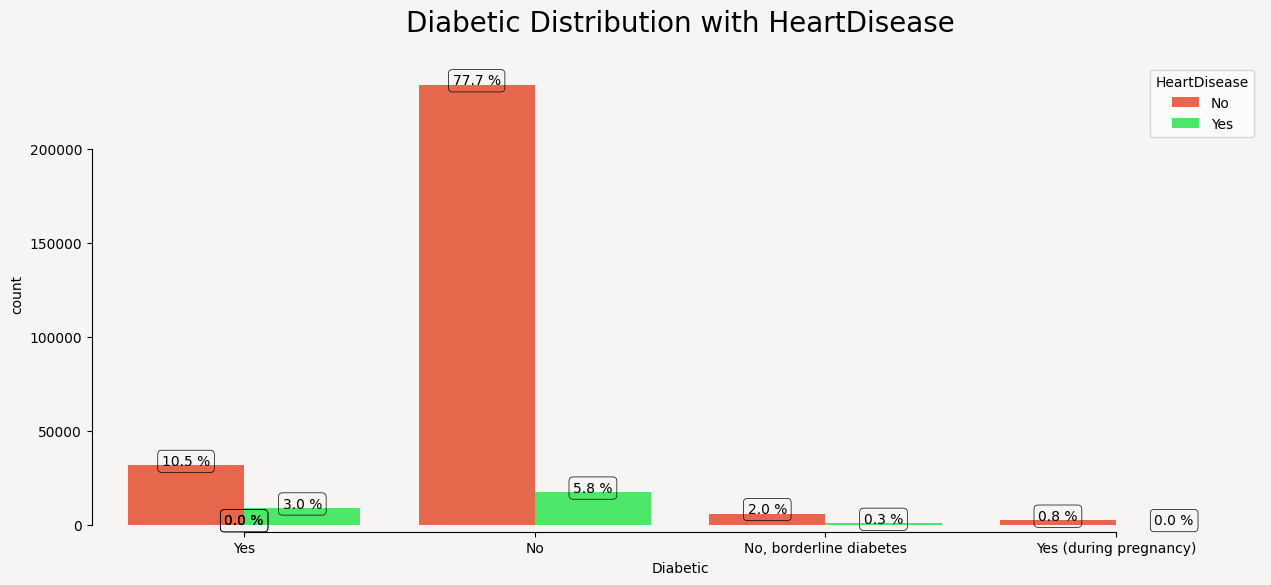

In [ ]:
plt.figure(figsize=(15, 6), facecolor='#F6F5F4')
total = float(len(df))

ax = sns.countplot(x='Diabetic', hue='HeartDisease', data=df, palette=mypal)
ax.set_facecolor('#F6F5F4')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, '{:1.1f} %'.format((height / total) * 100), ha="center",
            bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.5))

ax.set_title('Diabetic Distribution with HeartDisease', fontsize=20, y=1.05)
sns.despine(right=True)
sns.despine(offset=5, trim=True)

plt.show()

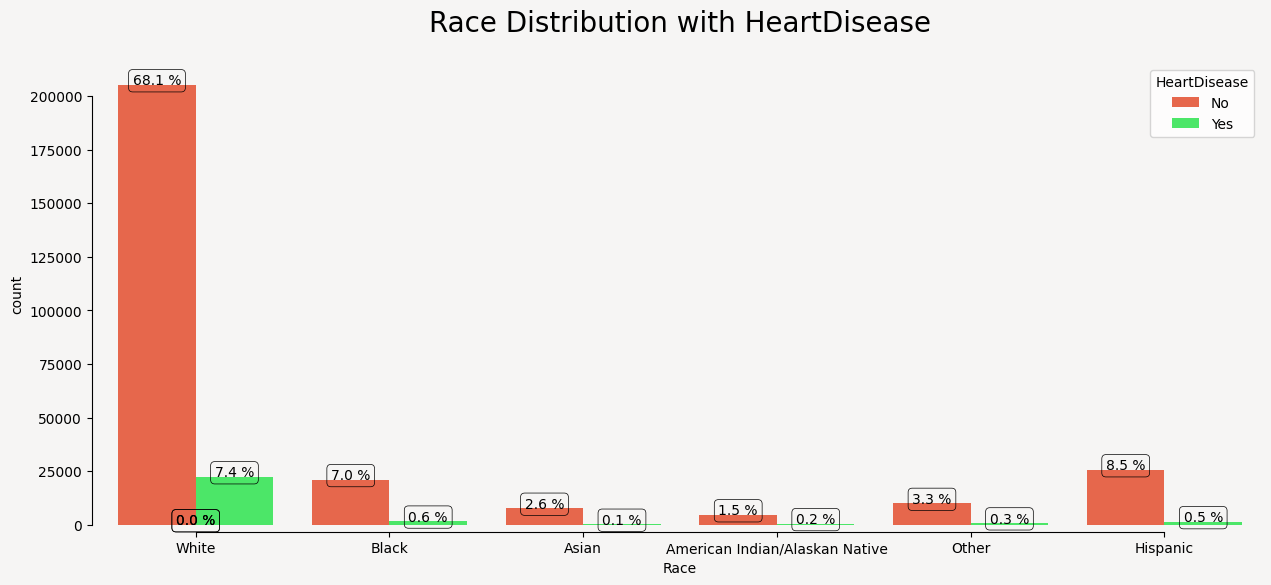

In [ ]:
plt.figure(figsize=(15, 6), facecolor='#F6F5F4')
total = float(len(df))

ax = sns.countplot(x='Race', hue='HeartDisease', data=df, palette=mypal)
ax.set_facecolor('#F6F5F4')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, '{:1.1f} %'.format((height / total) * 100), ha="center",
            bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.5))

ax.set_title('Race Distribution with HeartDisease', fontsize=20, y=1.05)
sns.despine(right=True)
sns.despine(offset=5, trim=True)

plt.show()

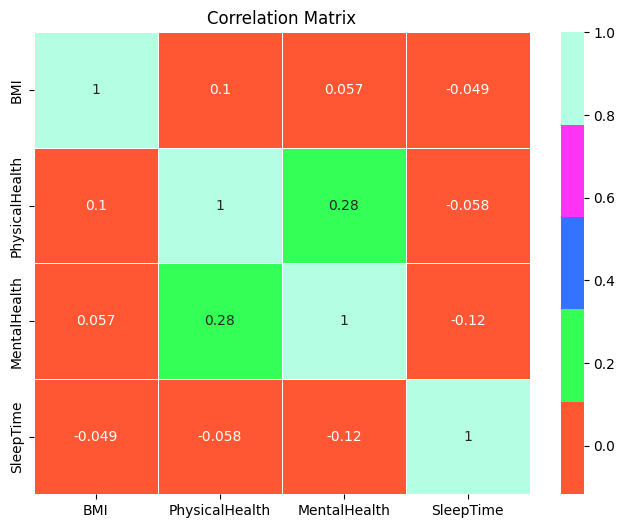

In [ ]:
numeric_features = ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime' ]
numeric_corr = df[numeric_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(numeric_corr, annot=True, cmap=sns.color_palette(mypal), linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
df1 = df.copy()
df1 = df1.replace({'No': 0, 'Yes': 1})

df1["Sex"] = df1["Sex"].replace({'Female': 0, 'Male': 1})

In [ ]:
diabetic_mapping = {
    'No': 0,
    'No, borderline diabetes': 0,
    'Yes': 1,
    'Yes (during pregnancy)': 1
}

df1['Diabetic'] = df1['Diabetic'].replace(diabetic_mapping).astype(int)

In [ ]:
race_mapping = {
    'American Indian/Alaskan Native': 0,
    'Asian': 1,
    'Black': 2,
    'Hispanic': 3,
    'Other': 4,
    'White': 5
}

df1['Race'] = df1['Race'].map(race_mapping).astype(int)

In [ ]:
gen_health_mapping = {
    'Poor': 0,
    'Fair': 1,
    'Good': 2,
    'Very good': 3,
    'Excellent': 4
}

df1['GenHealth'] = df1['GenHealth'].replace(gen_health_mapping).astype(int)

In [ ]:
age_mapping = {
    '18-24': 0,
    '25-29': 1,
    '30-34': 2,
    '35-39': 3,
    '40-44': 4,
    '45-49': 5,
    '50-54': 6,
    '55-59': 7,
    '60-64': 8,
    '65-69': 9,
    '70-74': 10,
    '75-79': 11,
    '80 or older': 12
}

df1['AgeCategory'] = df1['AgeCategory'].map(age_mapping).astype(int)

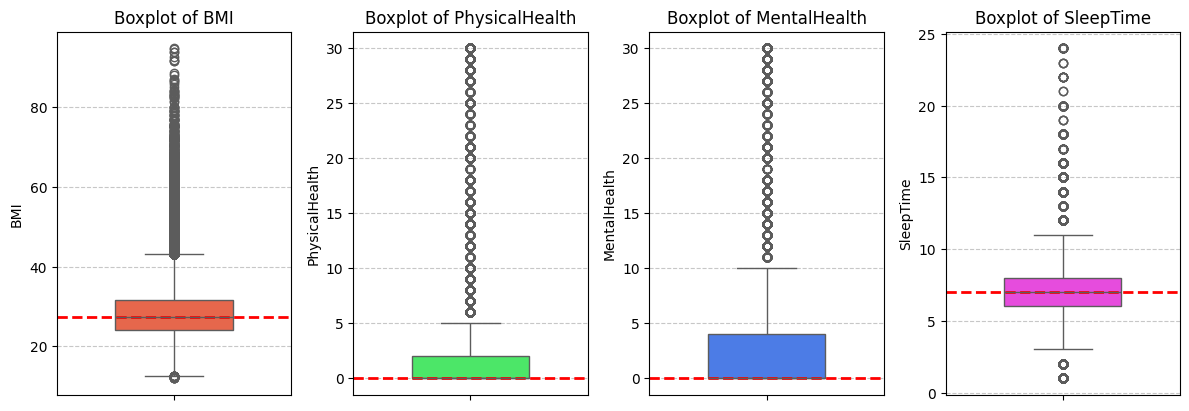

In [ ]:
numerical_cols = ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']

palette = sns.color_palette(mypal)

plt.figure(figsize=(12, 8))
for i, column in enumerate(numerical_cols, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(y=df1[column], color=palette[i-1], width=0.5)
    plt.axhline(y=df1[column].median(), color='red', linestyle='--', linewidth=2)
    plt.title(f'Boxplot of {column}', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()

In [ ]:
features_to_scale_robust = ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']


robust_scaler = RobustScaler()

df1[features_to_scale_robust] = robust_scaler.fit_transform(df1[features_to_scale_robust])

def count_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((series < lower_bound) | (series > upper_bound)).sum()

for feature in features_to_scale_robust:
    num_outliers = count_outliers(df1[feature])
    print(f'Number of outliers in {feature}: {num_outliers}')

Number of outliers in BMI: 8913
Number of outliers in PhysicalHealth: 47136
Number of outliers in MentalHealth: 39713
Number of outliers in SleepTime: 4542


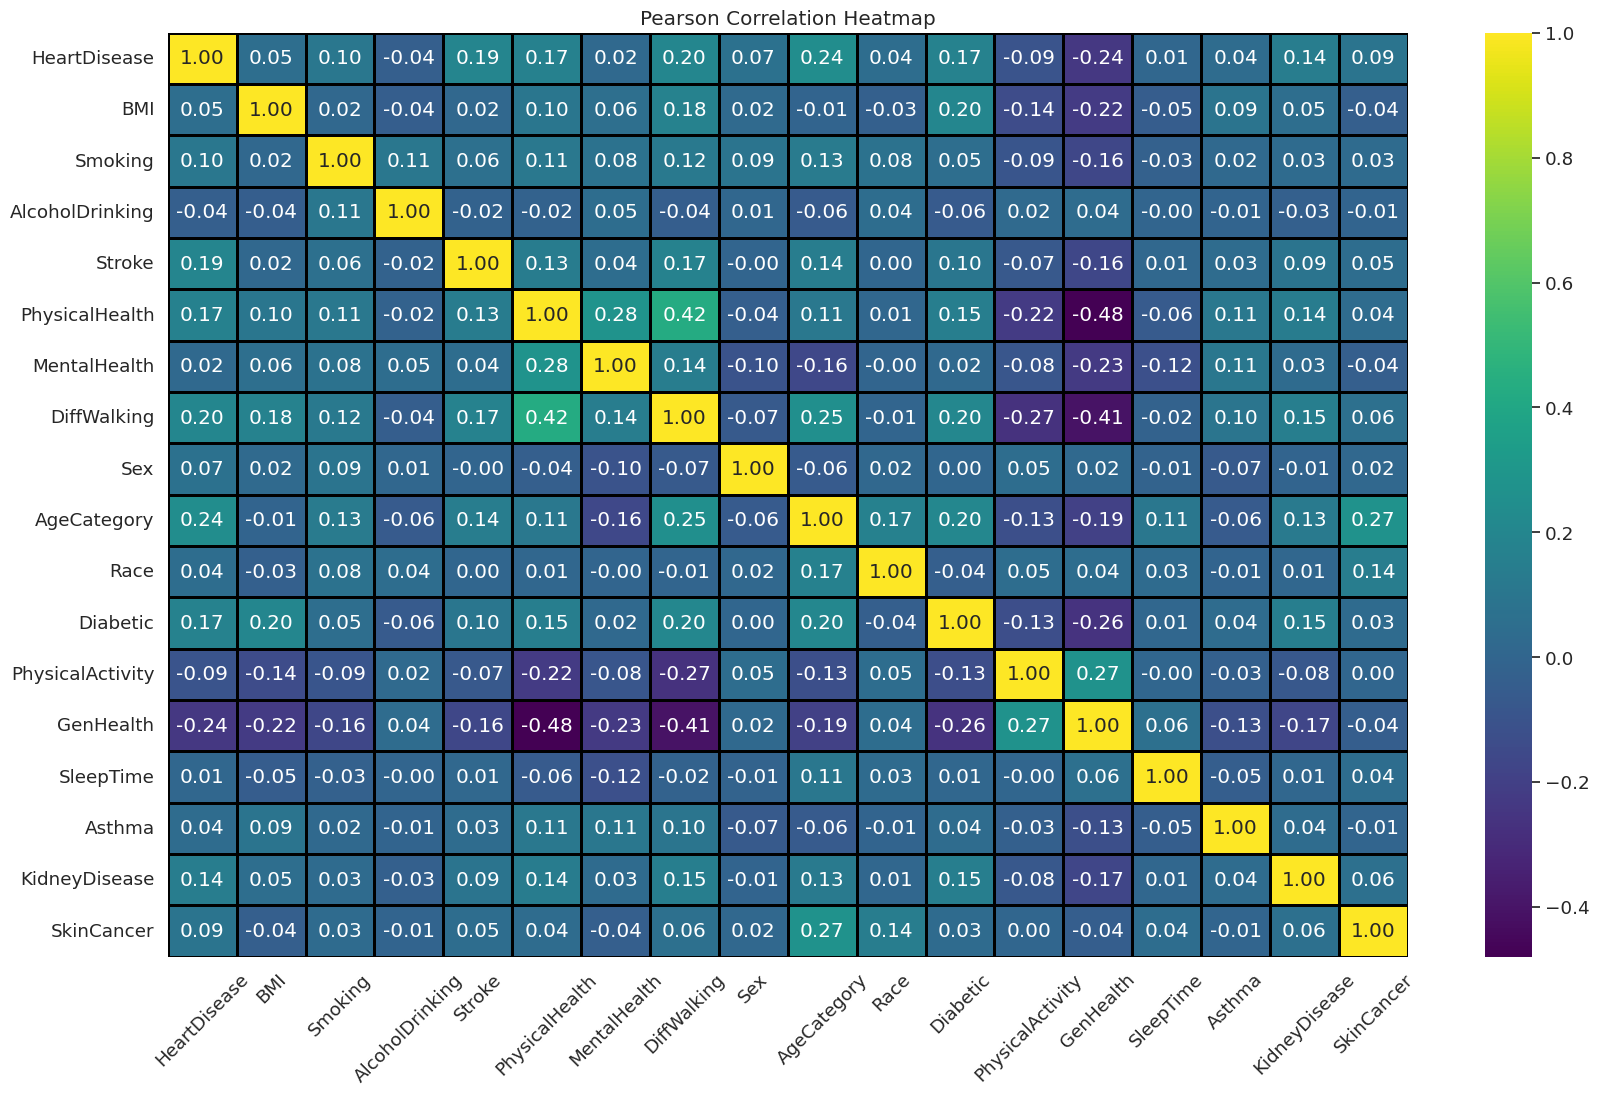

In [ ]:
pearson_corr = df1.corr(method='pearson')

# Plot heatmap
plt.figure(figsize=(20, 12))
sns.set(font_scale=1.2)
sns.heatmap(pearson_corr, annot=True, cmap='viridis', fmt=".2f", linewidths=1, linecolor='black')
plt.title('Pearson Correlation Heatmap')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [ ]:
df2 = df1.copy()

In [ ]:
X = df2.drop(['HeartDisease'], axis=1)
y = df2['HeartDisease']

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

<Axes: >

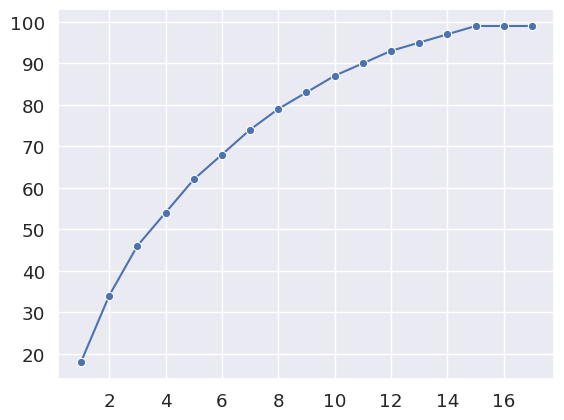

In [ ]:
decom = PCA(svd_solver='auto')
X_pca = decom.fit_transform(X_scaled)
ex_var = np.cumsum(np.round(decom.explained_variance_ratio_, 2) * 100)
sns.lineplot(y=ex_var, x=np.arange(1, len(ex_var) + 1), marker='o')

In [ ]:
param_dist_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
}

rf = RandomForestClassifier()

randomized_search_rf = RandomizedSearchCV(
    rf,
    param_distributions=param_dist_rf,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

randomized_search_rf.fit(X_train, y_train)

best_params_rf = randomized_search_rf.best_params_
print(f"Best Hyperparameters for Random Forest: {best_params_rf}")

best_rf_model = randomized_search_rf.best_estimator_

rf_predicted = best_rf_model.predict(X_test)

rf_acc_score = accuracy_score(y_test, rf_predicted)
rf_conf_matrix = confusion_matrix(y_test, rf_predicted)

print("\nConfusion Matrix for Random Forest:")
print(rf_conf_matrix)
print("\nAccuracy of Random Forest Classifier:", rf_acc_score * 100, '\n')
print("Classification Report for Random Forest:")
print(classification_report(y_test, rf_predicted))

with open ("/content/drive/MyDrive/Colab Notebooks/Data/heart_model.pkl", "wb") as f:
   pickle.dump(best_rf_model, f)
print("File written successfully.")

Best Hyperparameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 30, 'criterion': 'gini', 'bootstrap': False}

Confusion Matrix for Random Forest:
[[51181  3722]
 [ 3993 50887]]

Accuracy of Random Forest Classifier: 92.97250029603855 

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     54903
           1       0.93      0.93      0.93     54880

    accuracy                           0.93    109783
   macro avg       0.93      0.93      0.93    109783
weighted avg       0.93      0.93      0.93    109783

File written successfully.


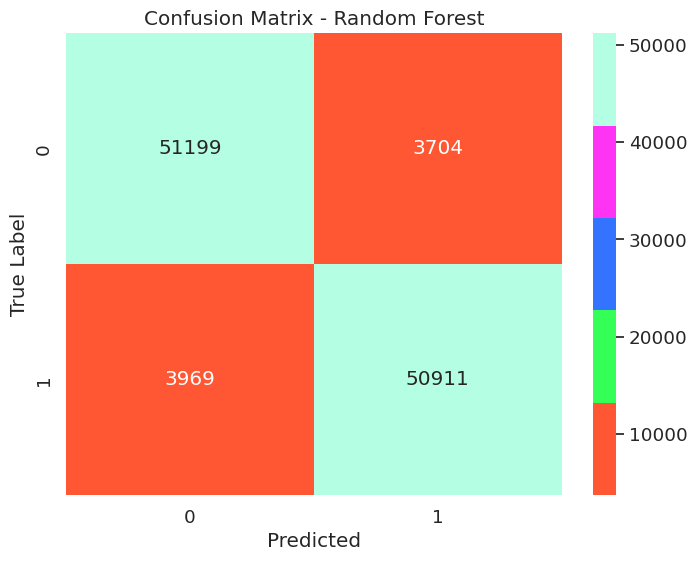

In [ ]:
y_pred_prob_rf = best_rf_model.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, (y_pred_prob_rf > 0.5).astype(int))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap=mypal, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Random Forest')
plt.show()

In [ ]:
import sklearn
print(sklearn.__version__)

1.2.2
